In [ ]:
import os
HOME = os.getcwd()

# install fastsam

%cd {HOME}

# install FastSAM
!git clone https://github.com/CASIA-IVA-Lab/FastSAM.git
!pip -q install -r FastSAM/requirements.txt
# install CLIP
!pip -q install git+https://github.com/openai/CLIP.git
# install SAM
!pip -q install git+https://github.com/facebookresearch/segment-anything.git

!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://huggingface.co/spaces/An-619/FastSAM/resolve/main/weights/FastSAM.pt
!wget -P {HOME}/weights -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys

np.set_printoptions(threshold=sys.maxsize)

In [56]:
from FastSAM import fastsam

def fast_sam(image_path, output_path):
  model = fastsam.FastSAM(f'{HOME}/weights/FastSAM.pt')

  DEVICE = 'cpu'
  everything_results = model(image_path, device=DEVICE, retina_masks=True, conf=0.4, iou=0.9,)

  prompt_process = fastsam.FastSAMPrompt(image_path, everything_results, device=DEVICE)

  # everything prompt
  # ann = prompt_process.everything_prompt()

  # text prompt
  # ann = prompt_process.text_prompt(text='the two green objects on the sides of the image')
  
  # ann = prompt_process.point_prompt(points=[[620, 360]], pointlabel=[1])
  
  ann = prompt_process.box_prompt(bboxes=[[0, 0, 870, 930], [1100, 0, 2000, 950]])

  prompt_process.plot(annotations=ann, output_path=output_path)

In [57]:
def pixels_to_micrometers(pixels):
    known_pixels = 1920
    known_micrometers = 3659.269
    micrometers = (pixels * known_micrometers) / known_pixels
    return round(micrometers, 2)

In [58]:
def calculate_percentage_error(experimental_value, theoretical_value):
  return round(np.mean(np.abs((theoretical_value - experimental_value) / theoretical_value)) *100, 2)

In [59]:
def brighten(image):
  # convert to LAB and extract L  channel
  LAB = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
  L = LAB[:,:,0]
  # threshold L channel with triangle method
  value, thresh = cv2.threshold(L, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  # threshold with adjusted value
  value = value + 10
  thresh = cv2.threshold(L, value, 255, cv2.THRESH_BINARY)[1]
  # invert threshold and make 3 channels
  thresh = 255 - thresh
  thresh = cv2.merge([thresh, thresh, thresh])
  gain = 2.5
  blue = cv2.multiply(image[:,:,0], gain)
  green = cv2.multiply(image[:,:,1], gain)
  red = cv2.multiply(image[:,:,2], gain)
  img_bright = cv2.merge([blue, green, red])
  # blend original and brightened using thresh as mask
  return np.where(thresh==255, img_bright, image)

In [60]:
def calculate_neck_properties(contour1, contour2):
  # Calculate the pairwise Euclidean distances between all points in the two contours
  distances = np.linalg.norm(contour1[:, None] - contour2, axis=-1)

  # Find the indices of the minimum distance in the distance matrix
  i, j = np.unravel_index(np.argmin(distances), distances.shape)
  
  # Get the nearest points
  nearest_points = (tuple(contour1[i]), tuple(contour2[j]))
  
  left_contour_rightmost_point = nearest_points[0]
  right_contour_leftmost_point = nearest_points[1]
  
  return pixels_to_micrometers(distances[i, j]), left_contour_rightmost_point, right_contour_leftmost_point

In [61]:
def collect_results(index, up_distance, down_distance, left_distance, right_distance, correct_values):
  results = []
  
  down_error = calculate_percentage_error(down_distance, correct_values['down'][index -1])
        
  results.append({'Image': index, 'Type': 'Down', 'Error': f'{down_distance} µm, {down_error} % error' })
  
  right_error = calculate_percentage_error(right_distance, correct_values['right'][index -1])
        
  results.append({'Image': index, 'Type': 'Right', 'Error': f'{right_distance} µm, {right_error} % error' })
  
  left_error = calculate_percentage_error(left_distance, correct_values['left'][index -1])
  
  results.append({'Image': index, 'Type': 'Left', 'Error': f'{left_distance} µm, {left_error} % error' })
  
  up_error = calculate_percentage_error(up_distance, correct_values['up'][index -1])
  
  results.append({'Image': index, 'Type': 'Up', 'Error': f'{up_distance} µm, {up_error} % error' })
  
  return results

In [62]:
def calculate_farthest_points(defects, contour):
  contour_farthest_points = [None, None]
  max_distances = [0, 0]
  
  if defects is None: return contour_farthest_points
  
  for i in range(defects.shape[0]):
      s, e, f, d = defects[i, 0]
      far = tuple(contour[f])
      distance = d / 256  # Scale the distance
      if distance > max_distances[0]:
          max_distances[1] = max_distances[0]
          contour_farthest_points[1] = contour_farthest_points[0]
          max_distances[0] = distance
          contour_farthest_points[0] = far
      elif distance > max_distances[1]:
          max_distances[1] = distance
          contour_farthest_points[1] = far
          
  return contour_farthest_points

In [63]:
import random as rng
rng.seed(12345)

def process_image(img, index, correct_values):
    top_crop = 60
    bottom_crop = 70
    left_crop = 60
    right_crop = 60
    
    roi = img[top_crop:-bottom_crop, left_crop:-right_crop]
    
    # roi = brighten(roi)
    
    PATH = f'./images/{index}.png'
    
    cv2.imwrite(PATH, roi)
    
    SAM_PATH = f'./sam_results/{index}.png'
    
    fast_sam(PATH, SAM_PATH)
    
    img = cv2.imread(SAM_PATH)
    
    brightened_image = img #brighten(img)

    standard_imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    brightened_imgray = cv2.cvtColor(brightened_image, cv2.COLOR_BGR2GRAY)
    
    _, brightened_thresh = cv2.threshold(
        brightened_imgray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    brightened_contours, hierarchy = cv2.findContours(
        brightened_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    img_with_line = img.copy()
    
    if (len(brightened_contours) < 2):
        cv2.drawContours(img_with_line, brightened_contours, -1, (0, 255, 0), 3)
        plt.imsave(f'./broken/{index}.png', img_with_line)
        print('Less than 2 contours found')
        return None, None
    
    brightened_filtered_contours = sorted(
        brightened_contours, key=lambda x: cv2.contourArea(x), reverse=True)[:2]
    
    brightened_contour1 = np.vstack(brightened_filtered_contours[0])
    brightened_contour2 = np.vstack(brightened_filtered_contours[1])
    
    neck_distance, left_contour_rightmost_point, right_contour_leftmost_point = calculate_neck_properties(brightened_contour1, brightened_contour2)
    
    results = []
        
    neck_error = calculate_percentage_error(neck_distance, correct_values['neck'][index -1])
        
    results.append({'Image': index, 'Type': 'Neck', 'Error': f'{neck_distance} µm, {neck_error} % error' })
    
    hull1 = cv2.convexHull(brightened_contour1, returnPoints=False)
    hull2 = cv2.convexHull(brightened_contour2, returnPoints=False)

    cv2.drawContours(img_with_line, brightened_filtered_contours, -1, (0, 255, 0), 3)
    
    hull_list = []
    for i in range(len(brightened_filtered_contours)):
        hull = cv2.convexHull(brightened_filtered_contours[i])
        hull_list.append(hull)

    defects1 = cv2.convexityDefects(brightened_contour1, hull1)
    defects2 = cv2.convexityDefects(brightened_contour2, hull2)
    
    contour1_farthest_points = calculate_farthest_points(defects1, brightened_contour1)
    contour2_farthest_points = calculate_farthest_points(defects2, brightened_contour2)
    
    contour1_start, contour1_end = np.array(contour1_farthest_points[0]), np.array(contour1_farthest_points[1])
    contour2_start, contour2_end = np.array(contour2_farthest_points[0]), np.array(contour2_farthest_points[1])
    
    if contour1_start[1] < contour1_end[1]:
        contour1_start, contour1_end = contour1_end, contour1_start
    
    if contour2_start[1] < contour2_end[1]:
        contour2_start, contour2_end = contour2_end, contour2_start
    
    down_distance = pixels_to_micrometers(
        np.linalg.norm(contour1_end - contour2_end))
    
    up_distance = pixels_to_micrometers(
        np.linalg.norm(contour1_start - contour2_start))
    
    left_distance = pixels_to_micrometers(
        np.linalg.norm(contour1_start - contour1_end))

    right_distance = pixels_to_micrometers(
        np.linalg.norm(contour2_start - contour2_end))
    
    results += collect_results(index, down_distance, up_distance, left_distance, right_distance, correct_values)

    cv2.line(img_with_line, contour1_start, contour2_start, (255, 0, 0), 2)

    cv2.line(img_with_line, contour1_end, contour2_end, (255, 0, 0), 2)

    cv2.line(img_with_line, contour1_start, contour1_end, (255, 0, 0), 2)

    cv2.line(img_with_line, contour2_start, contour2_end, (255, 0, 0), 2)

    cv2.line(img_with_line, left_contour_rightmost_point, right_contour_leftmost_point, (0, 0, 255), 2)

    return img_with_line, results


In [64]:
def process_sequence(path, correct_values, output_file):
    loaded, imgs = cv2.imreadmulti(path)
    processed_images = []
    num_images = len(imgs)
    all_results = []

    for i, img in enumerate(imgs):
        img_with_line, results = process_image(imgs[i], i + 1, correct_values)
        
        
        
        if results is not None: all_results.extend(results)
        if img_with_line is not None: processed_images.append(img_with_line)    
    
    return all_results, processed_images

In [65]:
from correct_values.correct_3_percent import CORRECT_3_PERCENT_NECK, CORRECT_3_PERCENT_LEFT, CORRECT_3_PERCENT_RIGHT, CORRECT_3_PERCENT_UP, CORRECT_3_PERCENT_DOWN
from correct_values.correct_5_percent import CORRECT_5_PERCENT_NECK, CORRECT_5_PERCENT_LEFT, CORRECT_5_PERCENT_RIGHT, CORRECT_5_PERCENT_UP, CORRECT_5_PERCENT_DOWN
from correct_values.correct_16_percent import CORRECT_16_PERCENT_NECK, CORRECT_16_PERCENT_LEFT, CORRECT_16_PERCENT_RIGHT, CORRECT_16_PERCENT_UP, CORRECT_16_PERCENT_DOWN

In [66]:

IMAGES_DATA = [
    {
        'path': 'data/16%.tif',
        'values': {
            'right': CORRECT_16_PERCENT_RIGHT,
            'left': CORRECT_16_PERCENT_LEFT,
            'up': CORRECT_16_PERCENT_UP,
            'down': CORRECT_16_PERCENT_DOWN,
            'neck': CORRECT_16_PERCENT_NECK,
        }
    },
    {
        'path': 'data/5%.tif',
        'values': {
            'right': CORRECT_5_PERCENT_RIGHT,
            'left': CORRECT_5_PERCENT_LEFT,
            'up': CORRECT_5_PERCENT_UP,
            'down': CORRECT_5_PERCENT_DOWN,
            'neck': CORRECT_5_PERCENT_NECK,
        }
    },
    {
        'path': 'data/3%.tif',
        'values': {
            'right': CORRECT_3_PERCENT_RIGHT,
            'left': CORRECT_3_PERCENT_LEFT,
            'up': CORRECT_3_PERCENT_UP,
            'down': CORRECT_3_PERCENT_DOWN,
            'neck': CORRECT_3_PERCENT_NECK,
        }
    }
]


In [67]:
sequences_results = []
all_processed_images = []

for i in range(len(IMAGES_DATA)):
    image_data = IMAGES_DATA[i]
    sequence_results, processed_images = process_sequence(image_data['path'], image_data['values'], f'results/{image_data["path"].split("/")[1]}')
    sequences_results.append(sequence_results)
    all_processed_images.append(processed_images)


image 1/1 /home/petko/projects/capillary-bridges-image-analysis/images/1.png: 544x1024 2 objects, 1330.1ms
Speed: 3.1ms preprocess, 1330.1ms inference, 11.3ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/petko/projects/capillary-bridges-image-analysis/images/2.png: 544x1024 3 objects, 1304.6ms
Speed: 3.0ms preprocess, 1304.6ms inference, 16.0ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/petko/projects/capillary-bridges-image-analysis/images/3.png: 544x1024 3 objects, 1309.0ms
Speed: 3.5ms preprocess, 1309.0ms inference, 15.0ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/petko/projects/capillary-bridges-image-analysis/images/4.png: 544x1024 3 objects, 1250.1ms
Speed: 2.2ms preprocess, 1250.1ms inference, 13.0ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/petko/projects/capillary-bridges-image-analysis/images/5.png: 544x1024 2 objects, 1900.5ms
Speed: 5.8ms preprocess, 1900.5ms inference, 14.2ms 

In [68]:
import pandas as pd

tables = []

for result in sequences_results:
  df = pd.DataFrame(result)

  table = df.pivot(index='Image', columns='Type', values='Error')
  tables.append(table)

In [69]:
from IPython.display import display_html

df1_styler = tables[0].style.set_table_attributes(
    "style='display:inline'").set_caption('16%')
df2_styler = tables[1].style.set_table_attributes(
    "style='display:inline'").set_caption('5%')
df3_styler = tables[2].style.set_table_attributes(
    "style='display:inline'").set_caption('3%')

display_html(df1_styler._repr_html_() + df2_styler._repr_html_() + df3_styler._repr_html_(), raw=True)


Type,Down,Left,Neck,Right,Up
Image,,,,,
1,"1600.29 µm, 5.69 % error","358.38 µm, 6.68 % error","1500.0 µm, 0.09 % error","420.66 µm, 25.24 % error","1935.63 µm, 23.62 % error"
2,"1035.13 µm, 30.73 % error","987.24 µm, 111.91 % error","5.39 µm, 99.6 % error","929.57 µm, 108.59 % error","1034.73 µm, 30.01 % error"
3,"1393.38 µm, 1.86 % error","535.56 µm, 2.66 % error","1238.81 µm, 0.52 % error","511.37 µm, 0.78 % error","1364.6 µm, 1.22 % error"
4,"1294.2 µm, 0.22 % error","680.4 µm, 1.35 % error","1061.57 µm, 1.0 % error","661.36 µm, 1.17 % error","1288.37 µm, 0.51 % error"
5,"1235.15 µm, 0.37 % error","791.05 µm, 3.36 % error","984.03 µm, 0.06 % error","766.62 µm, 2.37 % error","1248.36 µm, 1.89 % error"
6,"1189.45 µm, 1.27 % error","944.25 µm, 0.57 % error","858.18 µm, 2.39 % error","926.69 µm, 1.94 % error","1177.83 µm, 1.05 % error"
7,"1193.23 µm, 1.59 % error","1156.57 µm, 1.6 % error","730.25 µm, 1.52 % error","1136.17 µm, 1.56 % error","1156.86 µm, 0.06 % error"
8,"1834.24 µm, 56.16 % error","1345.49 µm, 1.12 % error","562.26 µm, 2.29 % error","1633.05 µm, 23.04 % error","1134.05 µm, 2.03 % error"
9,"1225.57 µm, 4.02 % error","1427.33 µm, 2.5 % error","406.06 µm, 0.44 % error","338.26 µm, 76.74 % error","1998.17 µm, 72.61 % error"


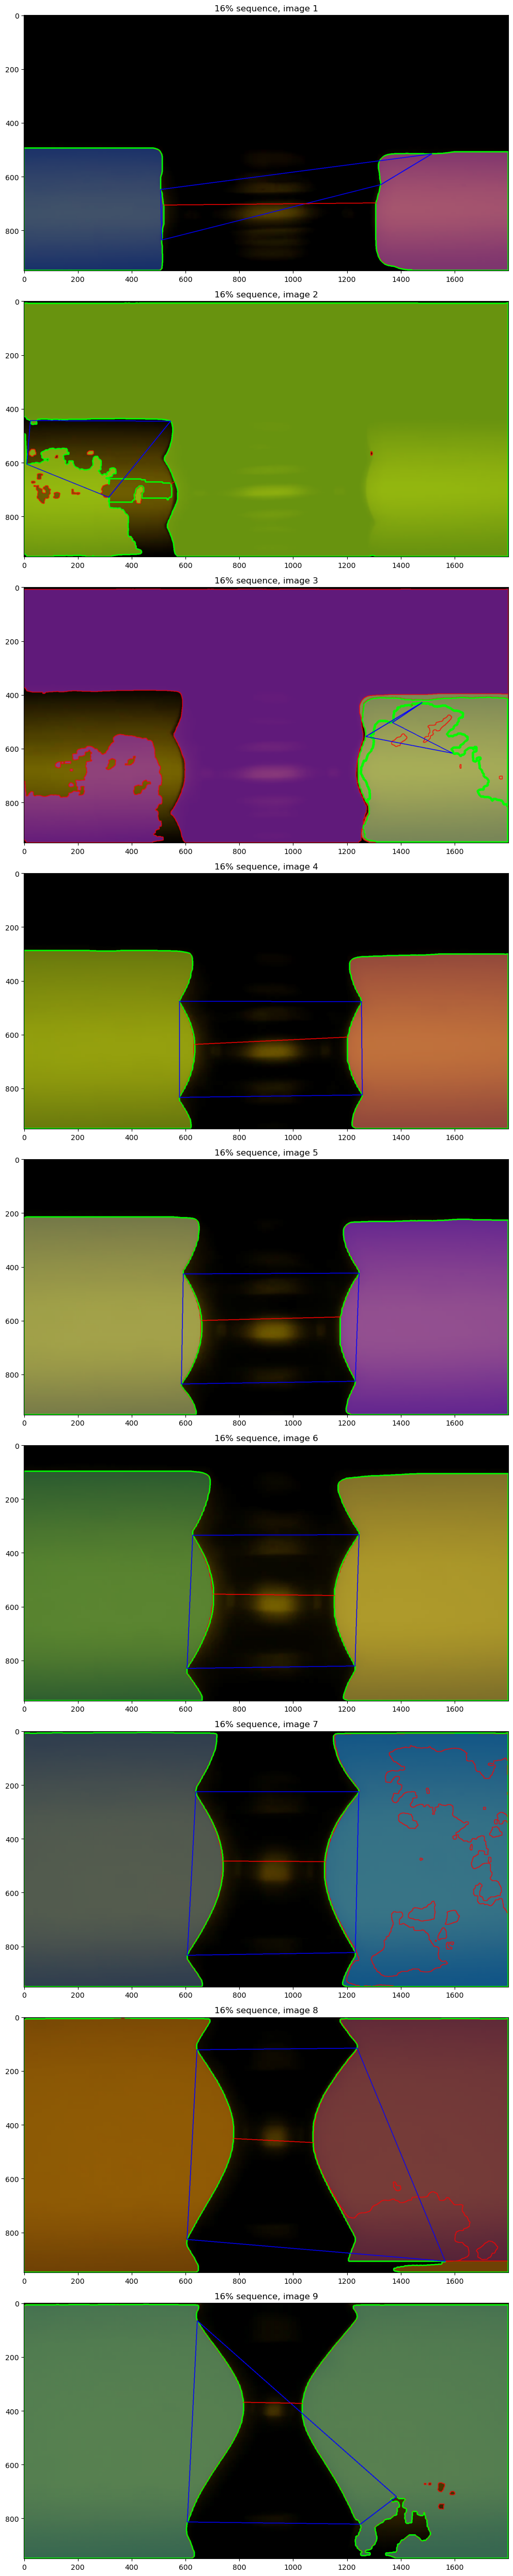

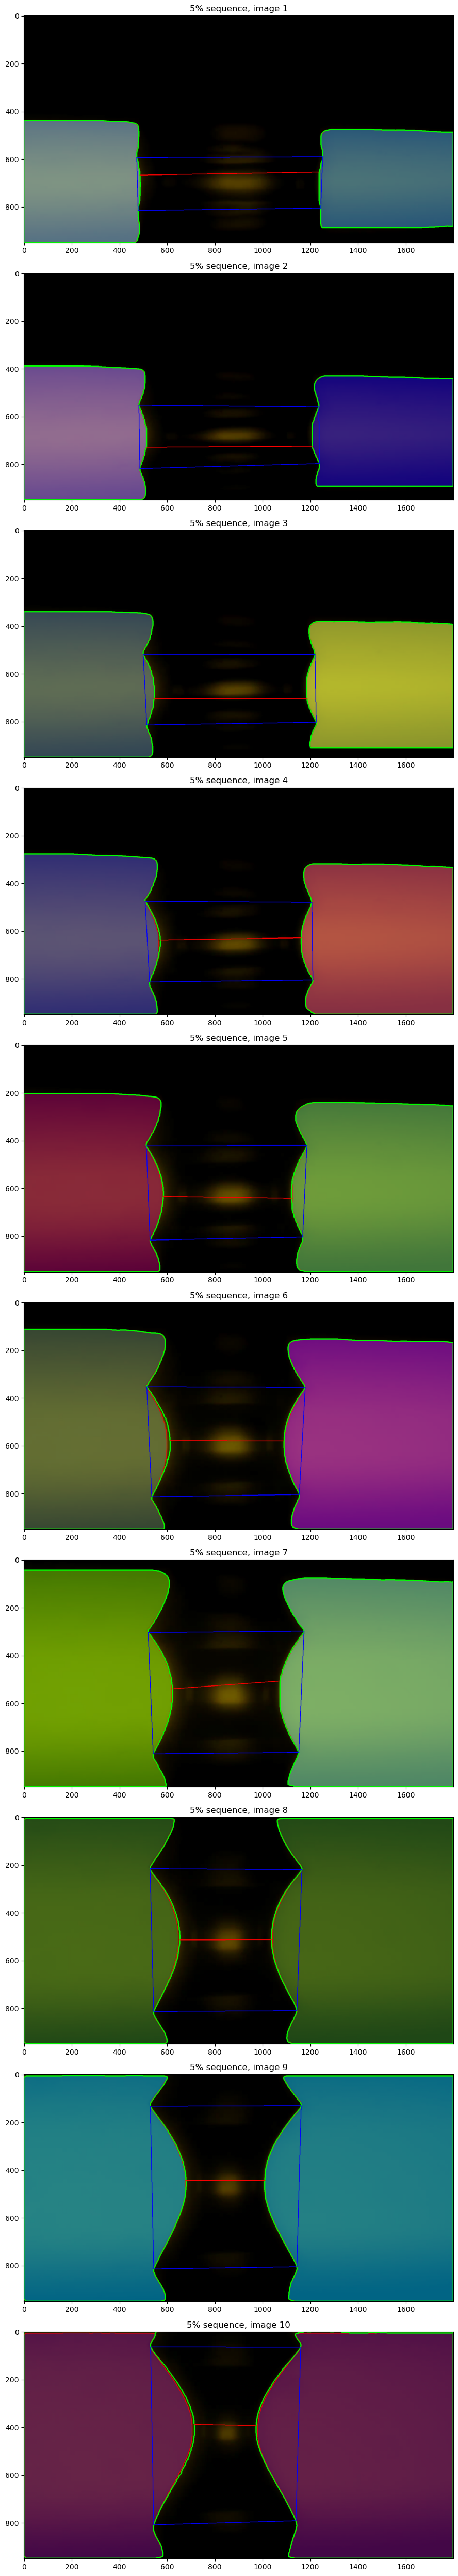

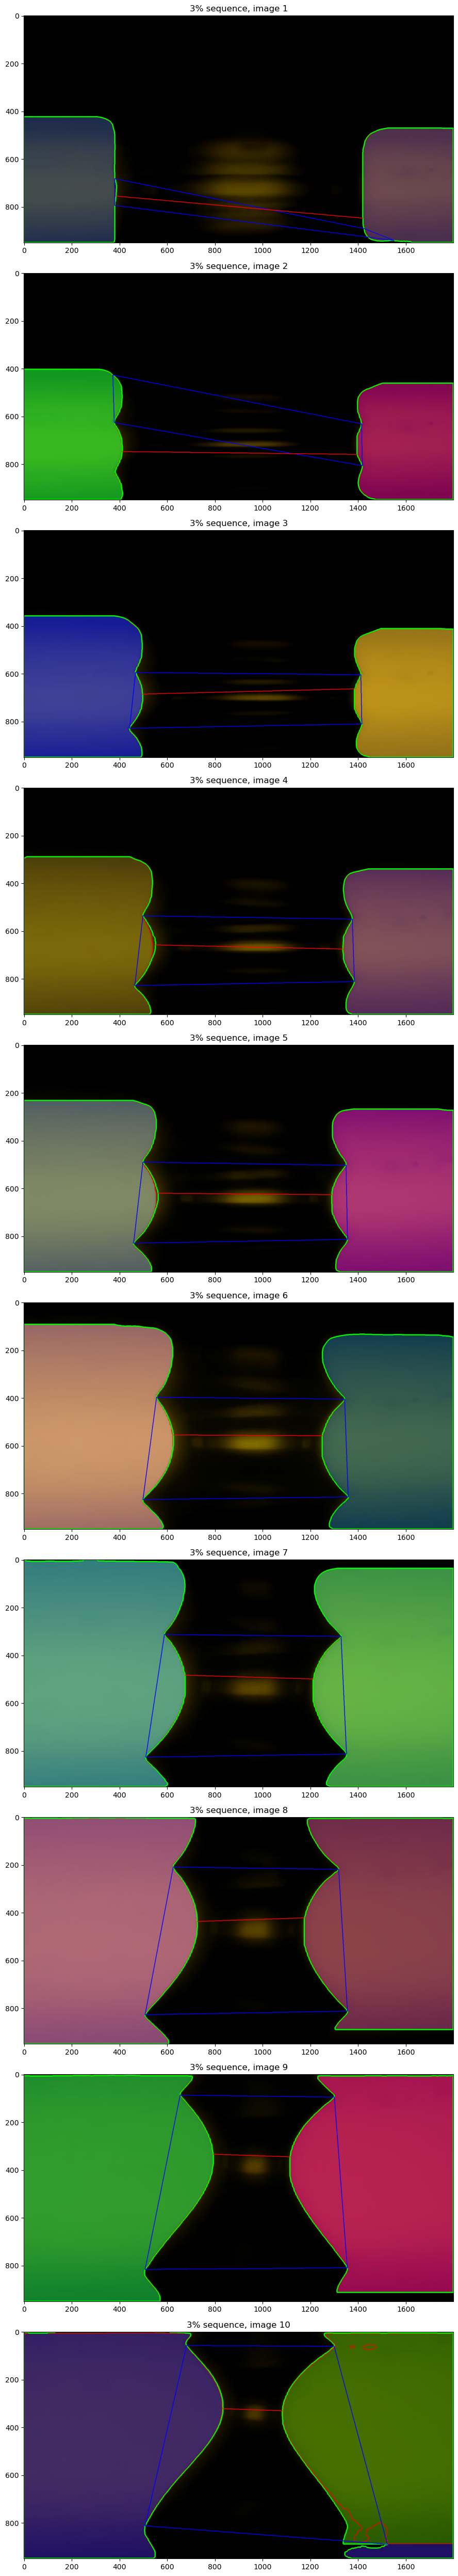

In [44]:
INDEX_TO_SEQUENCE = {
    0: '16%',
    1: '5%',
    2: '3%',
}

for i, image_sequence in enumerate(all_processed_images):
    plt.figure(figsize=(15, 50))
    
    for j, image in enumerate(image_sequence):
        plt.subplot(len(image_sequence), 1, j + 1)
        plt.imshow(cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB))
        plt.title(f'{INDEX_TO_SEQUENCE[i]} sequence, image {j + 1}')

    plt.tight_layout()
    plt.savefig(f'results/{IMAGES_DATA[i]["path"].split("/")[1]}.png')
    plt.show()
    plt.close()

In [12]:
import cv2

def access_webcam():
    cap = cv2.VideoCapture(0)  # Try using a different camera index (e.g., 1, 2, etc.)

    while True:
        ret, frame = cap.read()
        print('frame: ', frame)
        cv2.imshow('Webcam Feed', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

access_webcam()

frame:  None


[ WARN:0@21893.834] global cap_v4l.cpp:982 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@21893.834] global obsensor_uvc_stream_channel.cpp:156 getStreamChannelGroup Camera index out of range


error: OpenCV(4.8.0) /io/opencv/modules/highgui/src/window.cpp:971: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'imshow'
